### Intro to Simulation-Based Inference, previously named as Approximate Bayes Computation  (ABC) or Likelihood Free Inference (LFI). 
#### Traditionally, in the Bayes scheme you can get the posterior given the likelihood $p(x| \theta )$ and prior $p (\theta)$ distributions: 
$$
p (\theta | x) = \frac{ p(x | \theta) p(\theta) }{ p (x)},
$$
#### where the "evidence" is calculated by 
$$
p(x) = \int_{\theta}  p (x | \theta) p (\theta) d \theta.
$$

#### Traditionally, to get the posterior we use: MCMC, Nested Sampling, Hamiltonian Monte Carlo, etc. Furthermore, the SBI approach is different, motived by: 
* What if you don't even access to the likelihood? It isn't possible express $p(x | \theta)$ analytically. But you have a stochastic process that generates the data given a parameter, so you can only sample from it. 

Note: A stochastic process is a collection of random variables, that describes the evolution of a system of random viables over time. 


$$
\theta \rightarrow Simulator \rightarrow x
$$

Now the task becomes to find the posterior distribution of the parameters given our empirical "observed data".
* We can create unlimited $x_sim$ but we want find the parameters that mostly fit the observational data. 

## Rejection Appriximate Bayes Computation
### Resources: 
* Approximate Bayesian Computation: https://bayesiancomputationbook.com/markdown/chp_08.html 
* Overview of Approximate Bayesian Computation (Slides) by Chad M. Schafer: https://indico.cern.ch/event/937896/attachments/2074639/3483509/ABClectureSchaferHandout.pdf

#### This is one of the first algorithm for the intractable likelihood problem, i.e. we don't know $p(x | \theta)$, but how we can still get a sample of the posterior $p(\theta | x)$? 

#### ABC rejection algorithm (from: https://www.researchgate.net/publication/45880117_Tutorial_on_ABC_rejection_and_ABC_SMC_for_parameter_estimation_and_model_selection )
1. Define a prior distribution $P(\theta)$ and we would like to approximate the posterior distribution  $P(\theta | D_0)$ ($D_0$ is the experimental data). First, sample a parameter 
$\theta *$ from the prior distribution, this sampled parameter is called *a particle*.
2. From a simulate data set $D*$ according to some simulation framework $f(D|\theta*)$, we compare the simulated data ser $D*$ to the experimental data $D_0$ using a distance function $d$ and a tolerance $\epsilon$, we can use these for define a condition, we accept $\theta* $ if 
$$
d(D_0,D*) \leq \epsilon. 
$$
3. We accept $\theta*$ due $D*$ and $D_0$ are sufficiently close. 
4. We repeat the whole procesdure until $N$ particles have been accepted. They represent a sample from $(P  (\theta | d(D_0, D*)) \leq \epsilon )$, which approximates the posterior distribution. 

#### However, during the process many particles were rejected in the procedure, for which we have spent a lot of computational effort for simulation. ABC rejection is therefore computationally inefficient.

#### Note: If we simulate a deterministic dynamical model, we add some noise at the time points of interest. If we simulate a stochastic dynamical model, we do not add any additional noise to the trajectories.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import pandas as pd
import matplotlib.image as mpimg

In [2]:
# Estimating the mean of a normal distribution with known variancerando
# random seed
np.random.seed(42)
# this is the true mean value 
mean_tru = 2.5

# This is the "true data"

data_obs = np.random.normal(mean_tru,1.0,100)


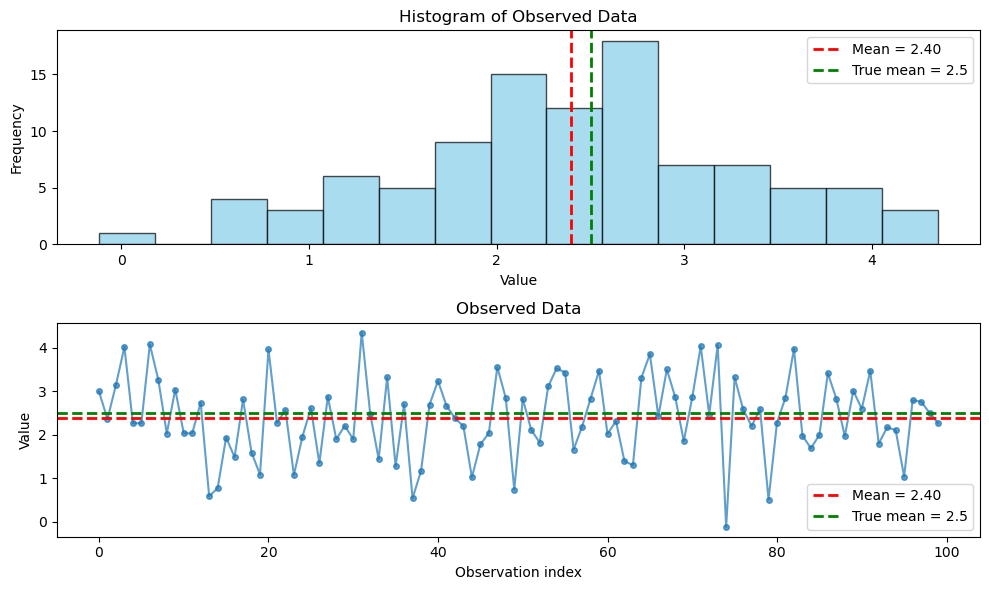

In [3]:
plt.figure(figsize=(10, 6))

# Histogram of the observed data
plt.subplot(2, 1, 1)
plt.hist(data_obs, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(data_obs), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(data_obs):.2f}')
plt.axvline(mean_tru, color='green', linestyle='--', linewidth=2, label=f'True mean = {mean_tru}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Observed Data')
plt.legend()

# Time series of the observed data
plt.subplot(2, 1, 2)
plt.plot(data_obs, 'o-', alpha=0.7, markersize=4)
plt.axhline(np.mean(data_obs), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(data_obs):.2f}')
plt.axhline(mean_tru, color='green', linestyle='--', linewidth=2, label=f'True mean = {mean_tru}')
plt.xlabel('Observation index')
plt.ylabel('Value')
plt.title('Observed Data')
plt.legend()

plt.tight_layout()


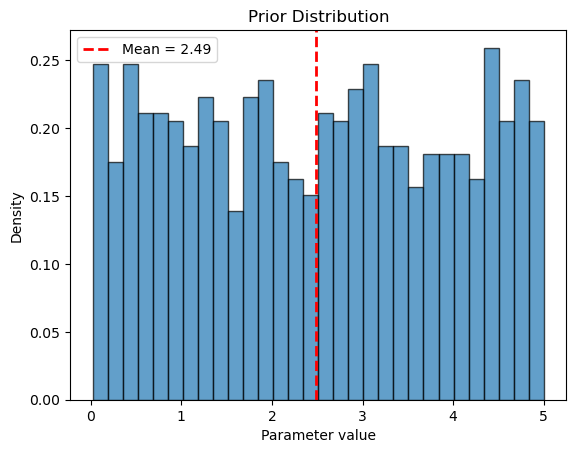

In [4]:
# The next step is define a prior distribution 
def prior():
    # uniform distribution from 0 to 5 
    return uniform.rvs(loc=0,scale=5)


prior_samples = [prior() for _ in range(1000)]
plt.hist(prior_samples, bins=30, density=True, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(prior_samples), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(prior_samples):.2f}')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.title('Prior Distribution')
plt.legend()
plt.show()


(array([0.06348214, 0.        , 0.        , 0.        , 0.25392857,
        0.12696429, 0.06348214, 0.19044643, 0.06348214, 0.31741072,
        0.444375  , 0.19044643, 0.19044643, 0.57133929, 0.31741072,
        0.63482143, 0.444375  , 0.31741072, 0.50785714, 0.19044643,
        0.25392857, 0.31741072, 0.19044643, 0.25392857, 0.        ,
        0.31741072, 0.        , 0.06348214, 0.        , 0.06348214]),
 array([-0.69880596, -0.54128134, -0.38375673, -0.22623212, -0.06870751,
         0.08881711,  0.24634172,  0.40386633,  0.56139095,  0.71891556,
         0.87644017,  1.03396478,  1.1914894 ,  1.34901401,  1.50653862,
         1.66406323,  1.82158785,  1.97911246,  2.13663707,  2.29416169,
         2.4516863 ,  2.60921091,  2.76673552,  2.92426014,  3.08178475,
         3.23930936,  3.39683397,  3.55435859,  3.7118832 ,  3.86940781,
         4.02693243]),
 <BarContainer object of 30 artists>)

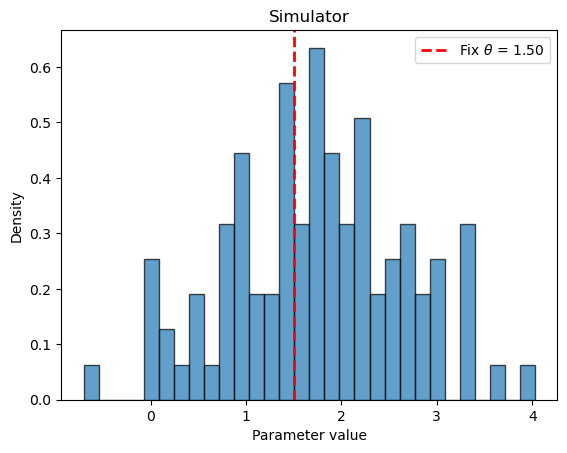

In [5]:
# step 3: Now we need define a simulatior, from a parameter theta 

def simulator(theta):
    return np.random.normal(theta,1,100)

# keep in main that this parameter represent the mean of the distribution 
fix_theta = 1.5
test_simulator1 = simulator(fix_theta)
plt.axvline(1.5, color='red', linestyle='--', linewidth=2, label=f'Fix $\\theta$ = {fix_theta:.2f}')
plt.legend()
plt.ylabel("Density")
plt.xlabel("Parameter value")
plt.title("Simulator")
plt.hist(test_simulator1, bins=30, density=True, alpha=0.7, edgecolor='black')


In [6]:
# step 4: We need to choose a rule of "closeness" of our simulations with the true observations.
# we use the simplest rule of distance for this 
def distance(observed, simulated):
    return abs(np.mean(observed) - np.mean(simulated))

# Test the distance function
test_distance = distance(data_obs,test_simulator1)
print(f"Distance between observed and simulated data: {test_distance:.3f}")


Distance between observed and simulated data: 0.648


In [7]:
# step 5: implement the ABC rejection algorith with the observational data, the prior distribution and 
# the simulator. 
def abc_rejection(prior, simulator, distance, observed_data, epsilon, n_accepted):
    """
    epsilon: tolerance threshold for accepting parameters
    n_accepted: number of particles to accept
    
    Returns:
    accepted_particles: list of accepted parameter values
    total_simulations: total number of simulations performed
    """
    
    # Initialize an empty list to store accepted particles
    accepted_particles = []
    total_simulations = 0
    
    print(f"Starting ABC rejection. Need to accept {n_accepted} particles.")
    
    while len(accepted_particles) < n_accepted:
        # Step 1: Sample a parameter from the prior distribution (a particle)
        theta_star = prior()
        
        # Step 2: Simulate data using the sampled parameter
        simulated_data = simulator(theta_star)
        
        # Count the total number of simulations
        total_simulations += 1
        
        # Step 3: Calculate distance between simulated and observed data
        d = distance(observed_data, simulated_data)
        
        # Step 4: Accept the particle if distance is within tolerance
        if d <= epsilon:
            accepted_particles.append(theta_star)
            
            # Print progress every 10 accepted particles
            if len(accepted_particles) % 1000 == 0:
                print(f"Accepted {len(accepted_particles)} particles. "
                      f"Acceptance rate: {len(accepted_particles)/total_simulations:.4f}")
    
    # Return the accepted particles
    print(f"Completed! Total simulations: {total_simulations}. "
          f"Final acceptance rate: {len(accepted_particles)/total_simulations:.4f}")
    
    return np.array(accepted_particles), total_simulations

In [8]:
# step 6: Run the rejection ABC algorithm 
epsilon = 0.002

# Number of particles to accept
n_accepted = 1000

# Run the ABC rejection algorithm
accepted_particles, total_simulations = abc_rejection(
    prior, simulator, distance, data_obs, epsilon, n_accepted
)

Starting ABC rejection. Need to accept 1000 particles.
Accepted 1000 particles. Acceptance rate: 0.0008
Completed! Total simulations: 1211620. Final acceptance rate: 0.0008



Algorithm efficiency: 0.0008 (0.08% of simulations were accepted)


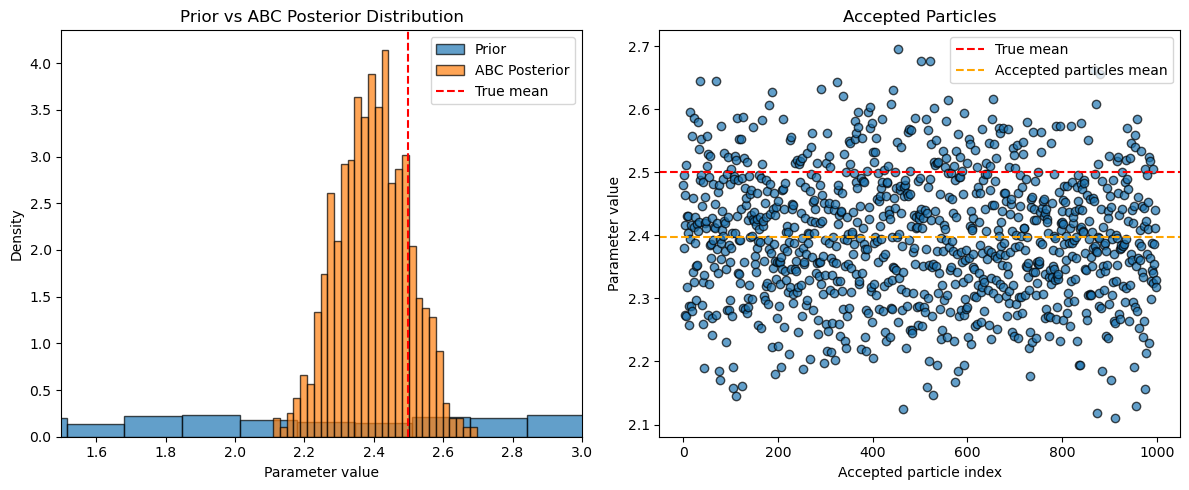


Summary statistics:
True parameter value: 2.500
Mean of accepted particles: 2.397
Standard deviation of accepted particles: 0.102
95% credible interval: [2.195, 2.586]


In [9]:
# Calculate efficiency
efficiency = n_accepted / total_simulations
print(f"\nAlgorithm efficiency: {efficiency:.4f} "
      f"({efficiency*100:.2f}% of simulations were accepted)")

# Plot results
plt.figure(figsize=(12, 5))

# Plot 1: Prior vs posterior distribution
plt.subplot(1, 2, 1)
plt.hist(prior_samples, bins=30, density=True, alpha=0.7, label='Prior', edgecolor='black')
plt.hist(accepted_particles, bins=30, density=True, alpha=0.7, label='ABC Posterior', edgecolor='black')
plt.axvline(mean_tru, color='red', linestyle='--', label='True mean')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.title('Prior vs ABC Posterior Distribution')
plt.xlim(1.5,3.0)
plt.legend()

# Plot 2: Accepted particles with distance information
plt.subplot(1, 2, 2)
plt.scatter(range(len(accepted_particles)), accepted_particles, alpha=0.7, edgecolor='black')
plt.axhline(mean_tru, color='red', linestyle='--', label='True mean')
plt.axhline(np.mean(accepted_particles), color='orange', linestyle='--', label='Accepted particles mean')
plt.xlabel('Accepted particle index')
plt.ylabel('Parameter value')
plt.title('Accepted Particles')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary statistics:")
print(f"True parameter value: {mean_tru:.3f}")
print(f"Mean of accepted particles: {np.mean(accepted_particles):.3f}")
print(f"Standard deviation of accepted particles: {np.std(accepted_particles):.3f}")
print(f"95% credible interval: [{np.percentile(accepted_particles, 2.5):.3f}, "
      f"{np.percentile(accepted_particles, 97.5):.3f}]")

## ABC for CPL model 
#### For this example we consider the CPL parametrization when the EoS for the DE is given by 
$$
w(z) = w_0 + w_a \frac{z}{1+z}

$$


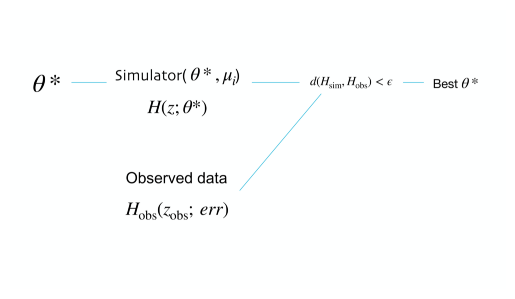

In [98]:
img = mpimg.imread('diagram_abc.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [10]:
Omega_m0 = 0.3
Omega_L0 = 0.7
H0 = 71
zvals = np.linspace(0,3,100)
def Hubble_cpl(z, w0, wa):
    
    matter_term = Omega_m0 * (1 + z)**3
    
    de_term = Omega_L0 * (1+z)**(3*(1+w0+wa)) * np.exp(-3*wa*z/(1+z))
    return  H0 * np.sqrt(matter_term + de_term)


w0_test, wa_test = -1, 0  # LCDM case
Hubble_lcdm = Hubble_cpl(zvals, w0_test, wa_test)


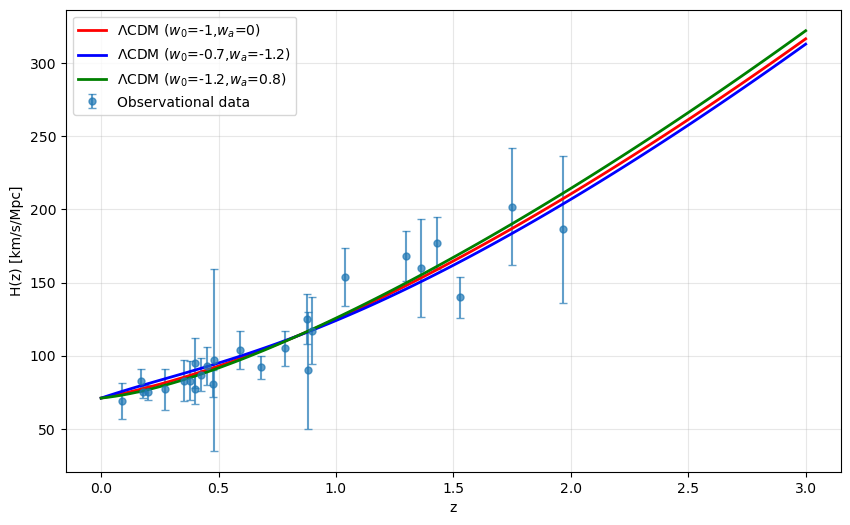

In [11]:
arr_hub = np.loadtxt('/home/alfonsozapata/SimpleMC/simplemc/data/Hz_all.dat')
z_obs= arr_hub[:,0]
hub_obs = arr_hub[:,1]
error_obs = arr_hub[:,2]


plt.figure(figsize=(10, 6))
plt.errorbar(z_obs, hub_obs, yerr=error_obs, fmt='o', markersize=5, 
             capsize=3, alpha=0.7, label='Observational data')
plt.plot(zvals,Hubble_lcdm, 'r-', linewidth=2, label='$\Lambda$CDM ($w_0$=-1,$w_a$=0)')
plt.plot(zvals,Hubble_cpl(zvals,w0 = -0.7,wa = -1.2), 'b-', linewidth=2, label='$\Lambda$CDM ($w_0$=-0.7,$w_a$=-1.2)')
plt.plot(zvals,Hubble_cpl(zvals,w0 = -1.2,wa = 0.8), 'g-', linewidth=2, label='$\Lambda$CDM ($w_0$=-1.2,$w_a$=0.8)')
plt.xlabel('z')
plt.ylabel('H(z) [km/s/Mpc]')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

plt.show()



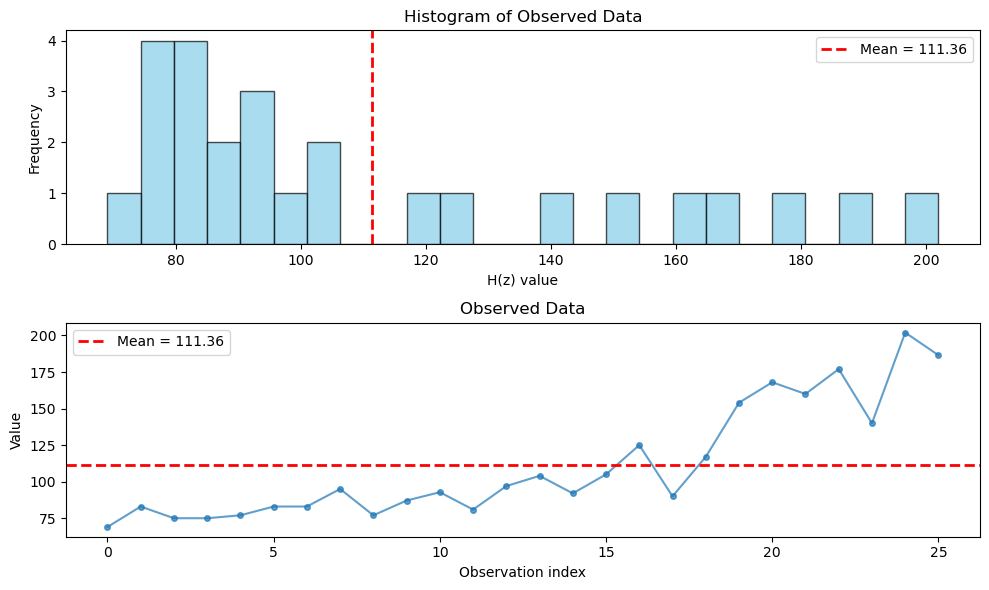


Additional statistics:
Observed data minimum: 69.000
Observed data maximum: 202.000
Observed data median: 93.900


In [12]:
plt.figure(figsize=(10, 6))

# Histogram of the observed data
plt.subplot(2, 1, 1)
plt.hist(hub_obs, bins=25, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(hub_obs), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(hub_obs):.2f}')
#plt.axvline(mean_tru, color='green', linestyle='--', linewidth=2, label=f'True mean = {mean_tru}')
plt.xlabel('H(z) value')
plt.ylabel('Frequency')
plt.title('Histogram of Observed Data')
plt.legend()

# Time series of the observed data
plt.subplot(2, 1, 2)
plt.plot(hub_obs, 'o-', alpha=0.7, markersize=4)
plt.axhline(np.mean(hub_obs), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(hub_obs):.2f}')
#plt.axhline(mean_tru, color='green', linestyle='--', linewidth=2, label=f'True mean = {mean_tru}')
plt.xlabel('Observation index')
plt.ylabel('Value')
plt.title('Observed Data')
plt.legend()

plt.tight_layout()
plt.show()

# Print some additional statistics
print(f"\nAdditional statistics:")
print(f"Observed data minimum: {np.min(hub_obs):.3f}")
print(f"Observed data maximum: {np.max(hub_obs):.3f}")
print(f"Observed data median: {np.median(hub_obs):.3f}")

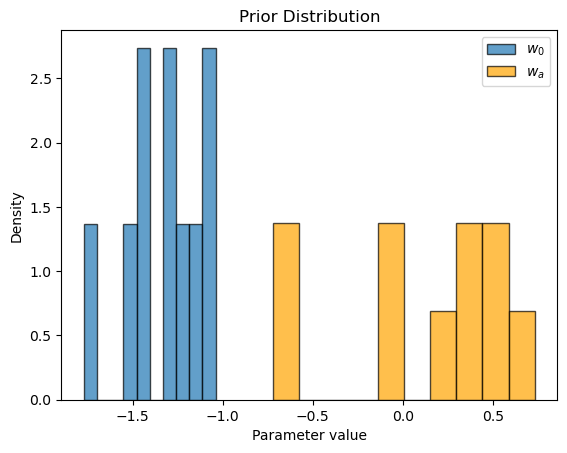

In [39]:
# we need define our priors for the parameters w0 and wa 
def prior_w0():
    return uniform.rvs(loc=-2.0, scale=1.0)
def prior_wa():
    return uniform.rvs(loc=-1.0, scale=2.0)
prior_samples_0 = [prior_w0() for _ in range(10)]
prior_samples_a = [prior_wa() for _ in range(10)]

plt.hist(prior_samples_0, bins=10, density=True, alpha=0.7, edgecolor='black',label = '$w_0$')
plt.hist(prior_samples_a, bins=10, density=True,color = 'orange', alpha=0.7, edgecolor='black',label = '$w_a$')

plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.title('Prior Distribution')
plt.legend()
plt.show()


(array([0.01561549, 0.01561549, 0.00780775, 0.03123099, 0.03123099,
        0.        , 0.00780775, 0.00780775, 0.        , 0.00780775,
        0.01561549, 0.00780775, 0.        , 0.00780775, 0.        ,
        0.        , 0.        , 0.00780775, 0.00780775, 0.00780775,
        0.        , 0.00780775, 0.        , 0.        , 0.        ,
        0.00780775, 0.        , 0.        , 0.        , 0.00780775]),
 array([ 75.99922458,  80.92529858,  85.85137259,  90.77744659,
         95.70352059, 100.6295946 , 105.5556686 , 110.48174261,
        115.40781661, 120.33389062, 125.25996462, 130.18603863,
        135.11211263, 140.03818664, 144.96426064, 149.89033464,
        154.81640865, 159.74248265, 164.66855666, 169.59463066,
        174.52070467, 179.44677867, 184.37285268, 189.29892668,
        194.22500069, 199.15107469, 204.07714869, 209.0032227 ,
        213.9292967 , 218.85537071, 223.78144471]),
 <BarContainer object of 30 artists>)

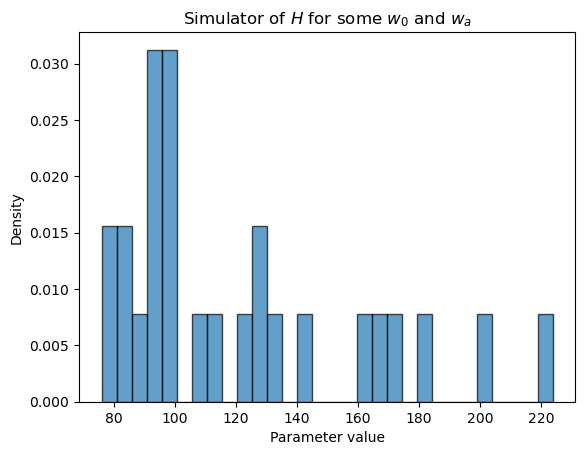

In [15]:
# Now, from the observable that we want compare. We use the following simulator 
def Hubble_sim(w0, wa):
    try:
        Hz_sim = np.array([Hubble_cpl(z, w0, wa) for z in z_obs])
        # Check for   # for NaN entries 
        if np.any(~np.isfinite(Hz_sim)) or np.any(Hz_sim <= 0):
            return None
        return Hz_sim
  
    except:
        return None

# now we test the simulator for some values 

w01, wa2  = -0.7, 0.1


hubble_sim1 = Hubble_sim(w01, wa2)
plt.ylabel("Density")
plt.xlabel("Parameter value")
plt.title("Simulator of $H$ for some $w_0$ and $w_a$")
plt.hist(hubble_sim1, bins=30, density=True, alpha=0.7, edgecolor='black')


#### we use the following def of the gaussian distance from (there are more options): https://bayesiancomputationbook.com/markdown/chp_08.html
$$
\sum_i \frac{|X_{\rm obs} - X_{\rm sim}|^2}{2 \epsilon_i^2}
$$
#### Here $\epsilon$ is the scalling parameter, for this case, the errors. 
#### Missing the factor of 2

In [16]:
def distance_hub(observed, errors, simulated):
    if simulated is None:
        return np.inf
    
    return np.sum((observed - simulated)**2 / errors**2)


In [17]:
# ABC Rejection Algorithm with the above elements 
def rejection_sim_cpl(prior_w0, prior_wa,simulator, distance, observed_data, errors, 
                           epsilon, n_accepted, n_sims_before_update=100000):
    accepted_particles = []
    total_simulations = 0
    distances = []
    
    print(f"Starting ABC rejection. Need to accept {n_accepted} particles.")
    print(f"Tolerance: $\epsilon$ = {epsilon}")
    
    while len(accepted_particles) < n_accepted:
        # Sample from prior
        w0_par = prior_w0()
        wa_par = prior_wa()
        
        simulated_data = simulator(w0_par, wa_par)
        
        total_simulations += 1
        
        d = distance(observed_data, errors, simulated_data)
        distances.append(d)
        
        # Accept if within tolerance
        if d <= epsilon:
            accepted_particles.append((w0_par, wa_par, d))
            
            if len(accepted_particles) % max(1, n_accepted//10) == 0:
                print(f"Accepted {len(accepted_particles)}/{n_accepted} particles. "
                      f"Acceptance rate: {len(accepted_particles)/total_simulations:.4f}")
        
        if total_simulations % n_sims_before_update == 0:
            print(f"Completed {total_simulations} simulations. "
                  f"Accepted: {len(accepted_particles)}. "
                  f"Current acceptance rate: {len(accepted_particles)/total_simulations:.6f}")
    
    print(f"Completed! Total sim: {total_simulations}. "
          f"Final acceptance rate: {len(accepted_particles)/total_simulations:.6f}")

    accepted_w0 = np.array([p[0] for p in accepted_particles])
    accepted_wa = np.array([p[1] for p in accepted_particles])
    accepted_d = np.array([p[2] for p in accepted_particles])
    
    return accepted_w0, accepted_wa, accepted_d, total_simulations, distances


In [83]:
epsilon1 = 15
n_accepted = 500
accepted_w0, accepted_wa, accepted_d, total_simulations, all_distances = rejection_sim_cpl(
    prior_w0, prior_wa, Hubble_sim, distance_hub, hub_obs, error_obs, 
    epsilon1, n_accepted)

Starting ABC rejection. Need to accept 500 particles.
Tolerance: $\epsilon$ = 15
Accepted 50/500 particles. Acceptance rate: 0.2033
Accepted 100/500 particles. Acceptance rate: 0.1730
Accepted 150/500 particles. Acceptance rate: 0.1732
Accepted 200/500 particles. Acceptance rate: 0.1691
Accepted 250/500 particles. Acceptance rate: 0.1779
Accepted 300/500 particles. Acceptance rate: 0.1757
Accepted 350/500 particles. Acceptance rate: 0.1731
Accepted 400/500 particles. Acceptance rate: 0.1759
Accepted 450/500 particles. Acceptance rate: 0.1748
Accepted 500/500 particles. Acceptance rate: 0.1703
Completed! Total sim: 2936. Final acceptance rate: 0.170300


In [84]:
# Grid and GA methos 
import time
from deap import base, creator, tools, algorithms
import random
# Define chi-squared function
def chi_squared(w0, wa, z_obs, hub_obs, error_obs, Hubble_cpl):
    H_theory = np.array([Hubble_cpl(z, w0, wa) for z in z_obs])
    return np.sum(((hub_obs - H_theory) / error_obs) ** 2)

# Define log-likelihood
def log_likelihood(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL):
    chi2 = chi_squared(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL)
    return -0.5 * chi2

# Define parameter space
w0_ini, w0_fin = -2,1.0
wa_ini, wa_fin = -1,2.0

# Define parameter space
w0_vals = np.linspace(w0_ini, w0_fin, 100)
wa_vals = np.linspace(wa_ini, wa_fin, 100)
W0, Wa = np.meshgrid(w0_vals, wa_vals)

# Compute log-likelihood using vectorized operations
start_grid = time.time()
log_L = np.array([[log_likelihood(w0, wa, z_obs, hub_obs, error_obs, Hubble_cpl) 
                    for w0 in w0_vals] for wa in wa_vals])

end_grid = time.time()
# Convert log-likelihood to likelihood for plotting
L = np.exp(log_L - np.max(log_L))  # Normalize for better numerical stability

#best-fit parameters
max_index = np.unravel_index(np.argmax(L), L.shape)
w0_best, wa_best = W0[max_index], Wa[max_index]


# Genetic Algorithm Implementation
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define individual initialization
def init_individual():
    return creator.Individual([random.uniform(w0_ini, w0_fin), random.uniform(wa_ini, wa_fin)])

# Define fitness function for GA
def fitness_function(ind):
    w0, wa = ind
    return (np.exp(log_likelihood(w0, wa, z_obs, hub_obs, error_obs, Hubble_cpl)),)  # Maximize likelihood


toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

start_ga = time.time()
population = toolbox.population(n=100)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=False)
end_ga = time.time()
ga_time = end_ga - start_ga


best_individual = tools.selBest(population, k=1)[0]
w0_best_ga, wa_best_ga = best_individual
print(f"Grid Best-fit parameters: w0 = {w0_best:.4f}, wa = {wa_best:.4f}")
print(f"GA Best-fit: w0 = {w0_best_ga:.4f}, wa = {wa_best_ga:.4f}")



/home/alfonsozapata/anaconda3/envs/cosmodesi/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/alfonsozapata/anaconda3/envs/cosmodesi/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Grid Best-fit parameters: w0 = -1.3030, wa = 0.7879
GA Best-fit: w0 = -1.2924, wa = 0.7456



Algorithm efficiency: 0.170300 (17.0300% of simulations were accepted)

Summary statistics for 500 accepted particles:
w_0: Mean = -1.204, Std = 0.105
w_0: 1-s credible interval = [-1.324, -1.089]
w_0: 95% credible interval = [-1.413, -1.036]
w_a: Mean = 0.198, Std = 0.469
w_a: 1-s credible interval = [-0.343, 0.748]
w_a: 95% credible interval = [-0.646, 0.954]
Best fit: w_0 = -1.277, w_a = 0.677 (distance = 14.166)
Correlation between $w_0$ and $w_a$: -0.814


/tmp/ipykernel_272800/3348638122.py:36: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(w0_best_ga, wa_best_ga, color='blue', edgecolor='black', marker='x', s=200,


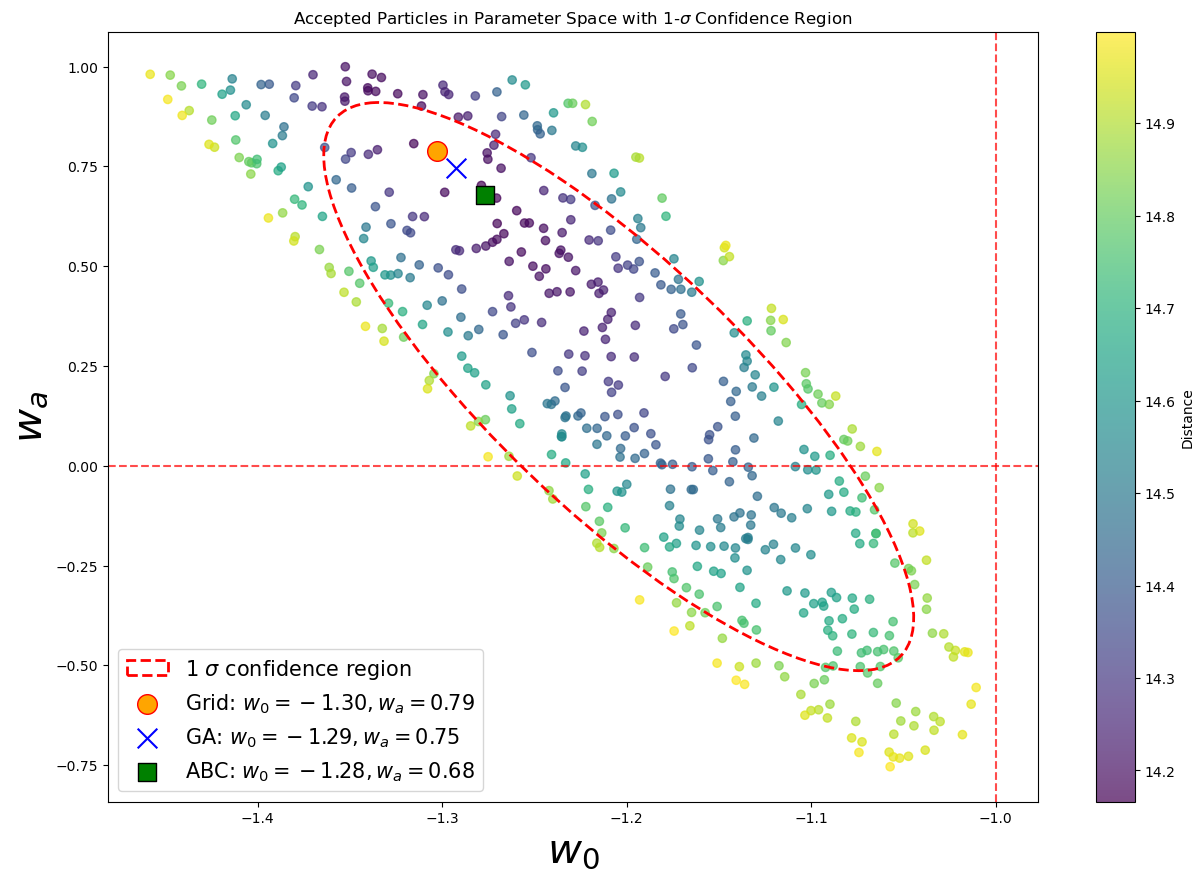

In [96]:
# Calculate efficiency
efficiency = n_accepted / total_simulations
print(f"\nAlgorithm efficiency: {efficiency:.6f} ({efficiency*100:.4f}% of simulations were accepted)")
plt.figure(figsize=(15, 10))

# Plot 1: Parameter space with accepted particles and confidence regions

scatter = plt.scatter(accepted_w0, accepted_wa, c=accepted_d, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Distance')

# Calculate mean and covariance for confidence ellipse
mean_w0, mean_wa = np.mean(accepted_w0), np.mean(accepted_wa)
cov = np.cov(accepted_w0, accepted_wa)

# Plot 1 sigma confidence ellipse (68.27% confidence region)
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# Calculate ellipse parameters
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
ellipse_radius = np.sqrt(chi2.ppf(0.6827, 2))  # For 1 sig in 2D
ellipse = Ellipse(xy=(mean_w0, mean_wa),
                 width=lambda_[0]*2*ellipse_radius,
                 height=lambda_[1]*2*ellipse_radius,
                 angle=np.degrees(np.arctan2(v[1, 0], v[0, 0])),
                 fill=False, edgecolor='red', linewidth=2, linestyle='--',
                 label='1 $\sigma$ confidence region')

plt.gca().add_patch(ellipse)

plt.axvline(-1, color='red', linestyle='--', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.scatter(w0_best, wa_best, color='orange', edgecolor='red', marker='o', s=200, 
            label=f'Grid: $w_0={w0_best:.2f}, w_a={wa_best:.2f}$')
plt.scatter(w0_best_ga, wa_best_ga, color='blue', edgecolor='black', marker='x', s=200, 
            label=f'GA: $w_0={w0_best_ga:.2f}, w_a={wa_best_ga:.2f}$')
plt.scatter( -1.277,  0.677 , color='green', edgecolor='black', marker='s', s=150, 
            label=f'ABC: $w_0={-1.277:.2f}, w_a={0.677:.2f}$')
plt.xlabel('$w_0$',fontsize=30)
plt.ylabel('$w_a$',fontsize=30)
plt.title('Accepted Particles in Parameter Space with 1-$\sigma$ Confidence Region')
plt.legend(fontsize=15)


# Print summary statistics including 1-s intervals
print(f"\nSummary statistics for {n_accepted} accepted particles:")
print(f"w_0: Mean = {np.mean(accepted_w0):.3f}, Std = {np.std(accepted_w0):.3f}")
print(f"w_0: 1-s credible interval = [{np.percentile(accepted_w0, 15.865):.3f}, {np.percentile(accepted_w0, 84.135):.3f}]")
print(f"w_0: 95% credible interval = [{np.percentile(accepted_w0, 2.5):.3f}, {np.percentile(accepted_w0, 97.5):.3f}]")
print(f"w_a: Mean = {np.mean(accepted_wa):.3f}, Std = {np.std(accepted_wa):.3f}")
print(f"w_a: 1-s credible interval = [{np.percentile(accepted_wa, 15.865):.3f}, {np.percentile(accepted_wa, 84.135):.3f}]")
print(f"w_a: 95% credible interval = [{np.percentile(accepted_wa, 2.5):.3f}, {np.percentile(accepted_wa, 97.5):.3f}]")
print(f"Best fit: w_0 = {best_w0:.3f}, w_a = {best_wa:.3f} (distance = {accepted_d[best_idx]:.3f})")

# Calculate correlation between parameters
correlation = np.corrcoef(accepted_w0, accepted_wa)[0, 1]
print(f"Correlation between $w_0$ and $w_a$: {correlation:.3f}")



### Some questions in this approach are: how can I define a metric for a comparison models? if there isn't a $\chi^2$, a $Log \mathcal{L}$ and then, a Bayesian Evidence?.
### Material: https://arxiv.org/pdf/2203.11276

### Using SN Ia data: In this case, we use a binned version of Pantheon:  

Number of data points: 40
Shape of flattened covariance: (1600,)
[0.02133073 0.02818581 0.01472022 0.01465537 0.021151   0.02626937
 0.02019356 0.01415468 0.02072897 0.0288652  0.00873785 0.01066114
 0.01009109 0.00682971 0.01088255 0.00916897 0.01055912 0.01148368
 0.01041825 0.00720243 0.01090711 0.00815169 0.00809753 0.0059879
 0.00716554 0.00661665 0.00627853 0.00851029 0.01332404 0.00882978
 0.01376445 0.00766388 0.01782218 0.01392193 0.0173698  0.01494122
 0.02166703 0.02454537 0.05027629 0.06023828]
Mean error: 0.015809
Min error: 0.005988
Max error: 0.060238


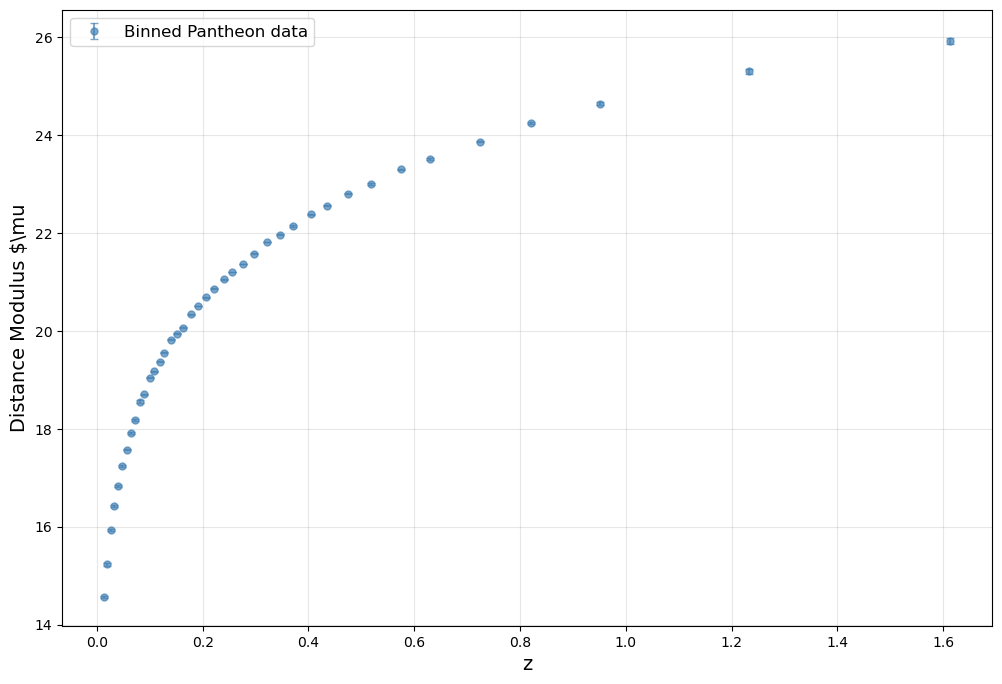

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
data_sn = np.loadtxt('/home/alfonsozapata/SimpleMC/simplemc/data/binned_pantheon.txt')
z_obs = data_sn[:, 1]  # Redshift
mu_obs = data_sn[:, 4]  # Distance modulus

# Load the covariance matrix (it's stored as a 1D array)
cov_flat = np.loadtxt('/home/alfonsozapata/SimpleMC/simplemc/data/binned_cov_pantheon.txt')

# Determine the size of the covariance matrix
n = int(np.sqrt(len(cov_flat)))  # Should be 40 for 40 data points
print(f"Number of data points: {n}")
print(f"Shape of flattened covariance: {cov_flat.shape}")

# Reshape the covariance matrix to 2D
cov_sn = cov_flat.reshape((n, n))


# Extract the diagonal (variances) and calculate standard errors
variances = np.diag(cov_sn)
errors = np.sqrt(variances)
print(errors)
print(f"Mean error: {np.mean(errors):.6f}")
print(f"Min error: {np.min(errors):.6f}")
print(f"Max error: {np.max(errors):.6f}")

# Create the main plot with error bars
plt.figure(figsize=(12, 8))

# Plot the data with error bars
plt.errorbar(z_obs, mu_obs, yerr=errors, fmt='o', markersize=5, 
             capsize=3, alpha=0.7, label='Binned Pantheon data', 
             color='steelblue', elinewidth=1.5)

plt.xlabel('z', fontsize=14)
plt.ylabel('Distance Modulus $\mu', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)





In [46]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d

# Define global cosmological parameters (or better, use a class)
Omega_m0 = 0.3
Omega_L0 = 0.7
h = 0.7
H0 = 100 * h  # km/s/Mpc
D_H = 2997.98 / h  # Hubble distance in Mpc

# Cache for interpolator
_dL_interp = None
_zmax_interp = None
_current_w0 = None
_current_wa = None

def hubble_normalized_cpl(z, w0, wa):
    """H(z)/H0 for CPL parameterization"""
    matter_term = Omega_m0 * (1 + z)**3
    de_term = Omega_L0 * (1+z)**(3*(1+w0+wa)) * np.exp(-3*wa*z/(1+z))
    return np.sqrt(matter_term + de_term)

def inverse_hubble_normalized_cpl(z, w0, wa):
    """1/(H(z)/H0) for integration"""
    return 1.0 / hubble_normalized_cpl(z, w0, wa)

def comoving_distance_cpl(z, w0, wa):
    """Comoving distance in Mpc"""
    integral, error = quad(
        lambda z_prime: inverse_hubble_normalized_cpl(z_prime, w0, wa),
        0, z, epsabs=1e-5, epsrel=1e-5, limit=100  # Reduced precision for speed
    )
    return D_H * integral

def luminosity_distance_cpl(z, w0, wa):
    """Luminosity distance in Mpc"""
    d_c = comoving_distance_cpl(z, w0, wa)
    return (1 + z) * d_c

def build_luminosity_distance_interpolator(w0, wa, zmax=2.0, npoints=100):
    """Build interpolator for faster distance calculations"""
    global _dL_interp, _zmax_interp, _current_w0, _current_wa
    
    zgrid = np.linspace(1e-4, zmax, npoints)
    dLgrid = np.array([luminosity_distance_cpl(z, w0, wa) for z in zgrid])
    
    _dL_interp = interp1d(zgrid, dLgrid, kind='cubic', 
                          bounds_error=False, fill_value='extrapolate')
    _zmax_interp = zmax
    _current_w0 = w0
    _current_wa = wa
    #print(f"Built interpolator for w0={w0}, wa={wa} up to z={zmax}")

def luminosity_distance_fast(z, w0, wa):
    """Fast luminosity distance using interpolation if available"""
    global _dL_interp, _zmax_interp, _current_w0, _current_wa
    
    # Check if we can use the interpolator
    if (_dL_interp is not None and _zmax_interp is not None and
        _current_w0 == w0 and _current_wa == wa):
        
        # Handle both scalar and array inputs
        z = np.asarray(z)
        if np.isscalar(z):
            if z <= _zmax_interp:
                return _dL_interp(z)
            else:
                return luminosity_distance_cpl(z, w0, wa)
        else:
            # For arrays, use interpolation where possible, fallback otherwise
            result = np.zeros_like(z)
            mask = z <= _zmax_interp
            result[mask] = _dL_interp(z[mask])
            result[~mask] = [luminosity_distance_cpl(zi, w0, wa) for zi in z[~mask]]
            return result
    else:
        # No suitable interpolator available, use direct calculation
        return luminosity_distance_cpl(z, w0, wa)

def distance_modulus(z, w0, wa):
    """Distance modulus μ = 5log10(dL) + 25"""
    try:
        dL = luminosity_distance_fast(z, w0, wa)
        return 5 * np.log10(dL) + 25
    except Exception as e:
        print(f"[ERROR] distance_modulus failed at z = {z}: {e}")
        return 1e6  # Large penalty for failed calculations


In [47]:
# Your simulation function
def mu_sim(w0, wa):
    """Simulate distance modulus for given parameters and redshifts"""
    # Build interpolator for these parameters for faster computation
    build_luminosity_distance_interpolator(w0, wa, zmax=max(z_obs)*1.1)
    
    mod = np.array([distance_modulus(z, w0, wa) for z in z_obs])
    return mod


Built interpolator for w0=-1.2, wa=0.7 up to z=1.7735300000000003


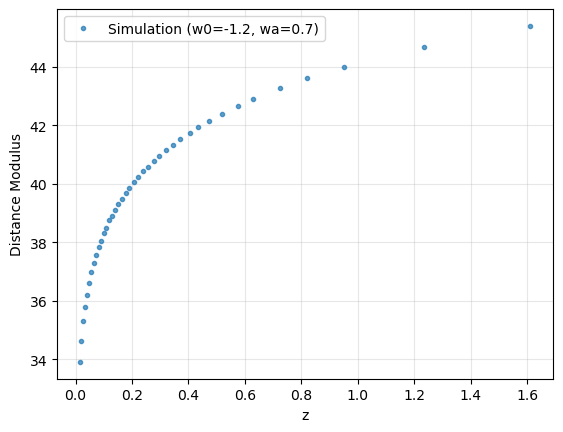

In [32]:
# Example usage
if __name__ == "__main__":
    # Test parameters
    w0_test, wa_test = -1.2, 0.7
    
    # Simulate distance moduli
    mu_simulated = mu_sim(w0_test, wa_test)
    
    # Plot the results
    import matplotlib.pyplot as plt
    plt.plot(z_obs, mu_simulated, '.', alpha=0.7, label=f'Simulation (w0={w0_test}, wa={wa_test})')
    plt.xlabel('z')
    plt.ylabel('Distance Modulus')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()  

In [45]:
## Now, consider a chi-2 distance to compare both data 
cov_inv = np.linalg.inv(cov_sn)
def distance_sn(data_sim,data_obs,cov):
    delta = data_obs - data_sim
    return np.dot(delta, np.dot(cov, delta))

distance_test = distance_sn(mu_simulated,mu_obs,cov_inv)
print(distance_test)

22342058387.23318


In [48]:
# ABC Rejection Algorithm with the above elements 
def rejection_sim_sn_cpl(prior_w0, prior_wa,simulator, distance, observed_data, cov, 
                           epsilon, n_accepted, n_sims_before_update=100000):
    accepted_particles = []
    total_simulations = 0
    distances = []
    
    print(f"Starting ABC rejection. Need to accept {n_accepted} particles.")
    print(f"Tolerance: $\epsilon$ = {epsilon}")
    
    while len(accepted_particles) < n_accepted:
        # Sample from prior
        w0_par = prior_w0()
        wa_par = prior_wa()
        
        simulated_data = simulator(w0_par, wa_par)
        
        total_simulations += 1
        
        d = distance(simulated_data,observed_data, cov)
        distances.append(d)
        
        # Accept if within tolerance
        if d <= epsilon:
            accepted_particles.append((w0_par, wa_par, d))
            
            if len(accepted_particles) % max(1, n_accepted//10) == 0:
                print(f"Accepted {len(accepted_particles)}/{n_accepted} particles. "
                      f"Acceptance rate: {len(accepted_particles)/total_simulations:.4f}")
        
        if total_simulations % n_sims_before_update == 0:
            print(f"Completed {total_simulations} simulations. "
                  f"Accepted: {len(accepted_particles)}. "
                  f"Current acceptance rate: {len(accepted_particles)/total_simulations:.6f}")
    
    print(f"Completed! Total sim: {total_simulations}. "
          f"Final acceptance rate: {len(accepted_particles)/total_simulations:.6f}")

    accepted_w0 = np.array([p[0] for p in accepted_particles])
    accepted_wa = np.array([p[1] for p in accepted_particles])
    accepted_d = np.array([p[2] for p in accepted_particles])
    
    return accepted_w0, accepted_wa, accepted_d, total_simulations, distances


In [58]:
epsilon1 = 100000000000
n_accepted = 500
accepted_w0, accepted_wa, accepted_d, total_simulations, all_distances = rejection_sim_sn_cpl(
    prior_w0, prior_wa,mu_sim ,distance_sn,mu_obs,cov_inv, 
    epsilon1, n_accepted)



Starting ABC rejection. Need to accept 500 particles.
Tolerance: $\epsilon$ = 100000000000
Accepted 50/500 particles. Acceptance rate: 1.0000
Accepted 100/500 particles. Acceptance rate: 1.0000
Accepted 150/500 particles. Acceptance rate: 1.0000
Accepted 200/500 particles. Acceptance rate: 1.0000
Accepted 250/500 particles. Acceptance rate: 1.0000
Accepted 300/500 particles. Acceptance rate: 1.0000
Accepted 350/500 particles. Acceptance rate: 1.0000
Accepted 400/500 particles. Acceptance rate: 1.0000
Accepted 450/500 particles. Acceptance rate: 1.0000
Accepted 500/500 particles. Acceptance rate: 1.0000
Completed! Total sim: 500. Final acceptance rate: 1.000000



Summary statistics for 500 accepted particles:
w_0: Mean = -1.497, Std = 0.287
w_0: 1-s credible interval = [-1.838, -1.138]
w_0: 95% credible interval = [-1.981, -1.024]
w_a: Mean = -0.019, Std = 0.584
w_a: 1-s credible interval = [-0.711, 0.670]
w_a: 95% credible interval = [-0.957, 0.942]


Text(0, 0.5, '$w_a$')

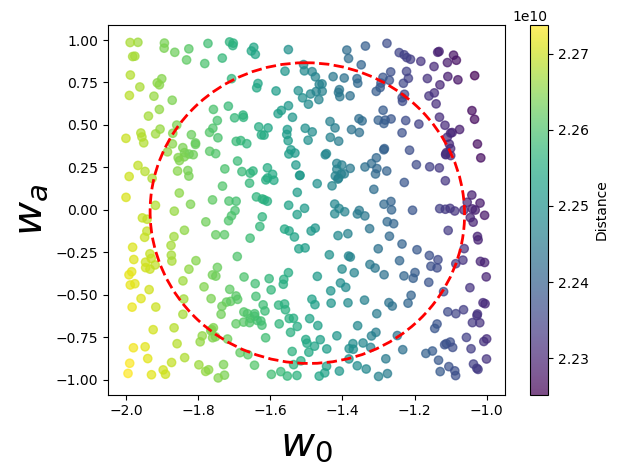

In [59]:
scatter = plt.scatter(accepted_w0, accepted_wa, c=accepted_d, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Distance')


mean_w0, mean_wa = np.mean(accepted_w0), np.mean(accepted_wa)
cov = np.cov(accepted_w0, accepted_wa)

# Plot 1 sigma confidence ellipse (68.27% confidence region)
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# Calculate ellipse parameters
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
ellipse_radius = np.sqrt(chi2.ppf(0.6827, 2))  # For 1 sig in 2D
ellipse = Ellipse(xy=(mean_w0, mean_wa),
                 width=lambda_[0]*2*ellipse_radius,
                 height=lambda_[1]*2*ellipse_radius,
                 angle=np.degrees(np.arctan2(v[1, 0], v[0, 0])),
                 fill=False, edgecolor='red', linewidth=2, linestyle='--',
                 label='1 $\sigma$ confidence region')

plt.gca().add_patch(ellipse)
print(f"\nSummary statistics for {n_accepted} accepted particles:")
print(f"w_0: Mean = {np.mean(accepted_w0):.3f}, Std = {np.std(accepted_w0):.3f}")
print(f"w_0: 1-s credible interval = [{np.percentile(accepted_w0, 15.865):.3f}, {np.percentile(accepted_w0, 84.135):.3f}]")
print(f"w_0: 95% credible interval = [{np.percentile(accepted_w0, 2.5):.3f}, {np.percentile(accepted_w0, 97.5):.3f}]")
print(f"w_a: Mean = {np.mean(accepted_wa):.3f}, Std = {np.std(accepted_wa):.3f}")
print(f"w_a: 1-s credible interval = [{np.percentile(accepted_wa, 15.865):.3f}, {np.percentile(accepted_wa, 84.135):.3f}]")
print(f"w_a: 95% credible interval = [{np.percentile(accepted_wa, 2.5):.3f}, {np.percentile(accepted_wa, 97.5):.3f}]")
plt.xlabel('$w_0$',fontsize=30)
plt.ylabel('$w_a$',fontsize=30)
